In [ ]:
# Import modules and mount google drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
#from google.colab import drive

#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Configure path and categories
#base_path = "/content/gdrive/My Drive/Colab Notebooks"
base_path = os.getcwd()
data_path = base_path + "/dataset"
categories = ["Faces", "cougar_face", "flamingo", "nautilus", "sunflower", "Faces_easy", "dalmatian", "headphone", "pagoda", "tick", "brontosaurus", "dollar_bill", "lotus", "soccer_ball", "windsor_chair", "car_side", "dragonfly", "menorah", "stop_sign", "yin_yang"]

# Add codewords for dictionary size.
codewords = [10, 20, 30, 40, 50]

In [ ]:
# Check number of training images and test images per categories
test_length = 5
image_length = 30
count = 0

total_test = test_length * len(categories)

train_path = []
train_label = []
train_features = np.array([])
accuracy_result = []

# Create detector for feature extraction
detector = cv2.ORB_create()

In [ ]:
# Extract features from training images.
for index, item in enumerate(categories):

  category_path = data_path + "/train/" + item

  for index2 in range(image_length):

    image_path = category_path + "/image_%04d.jpg" % (index2 + 1)
    train_path.append(image_path)
    train_label.append(index)

    img = cv2.imread(image_path)
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    kpt, desc = detector.detectAndCompute(gimg, None)

    if train_features.size == 0:
      train_features = np.float32(desc)
    else:
      train_features = np.append(train_features, np.float32(desc), axis=0)

    count += 1
    print('%d/%d - %s - %d feature points are detected\n' % (count, image_length*20, image_path, desc.shape[0]))

1/600 - /content/gdrive/My Drive/Colab Notebooks/dataset/train/Faces/image_0001.jpg - 492 feature points are detected

2/600 - /content/gdrive/My Drive/Colab Notebooks/dataset/train/Faces/image_0002.jpg - 500 feature points are detected

3/600 - /content/gdrive/My Drive/Colab Notebooks/dataset/train/Faces/image_0003.jpg - 495 feature points are detected

4/600 - /content/gdrive/My Drive/Colab Notebooks/dataset/train/Faces/image_0004.jpg - 500 feature points are detected

5/600 - /content/gdrive/My Drive/Colab Notebooks/dataset/train/Faces/image_0005.jpg - 500 feature points are detected

6/600 - /content/gdrive/My Drive/Colab Notebooks/dataset/train/Faces/image_0006.jpg - 500 feature points are detected

7/600 - /content/gdrive/My Drive/Colab Notebooks/dataset/train/Faces/image_0007.jpg - 500 feature points are detected

8/600 - /content/gdrive/My Drive/Colab Notebooks/dataset/train/Faces/image_0008.jpg - 498 feature points are detected

9/600 - /content/gdrive/My Drive/Colab Notebooks

In [ ]:
# Generate criteria for K-means classification
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)

In [ ]:
# Iterate training and testing as much as codeword list.
for codeword in codewords:

  # Generate dictionary with given codeword by using K-means clustering
  dictionary_size = codeword
  dictionary_file = base_path + "/2dictioanary(codeword" + str(codeword) + ").npy"
  ret, label, dictionary = cv2.kmeans(train_features, dictionary_size, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  np.save(dictionary_file, dictionary)

  # Generate K-Nearest model for training images
  knn = cv2.ml.KNearest_create()
  knn.train(dictionary, cv2.ml.ROW_SAMPLE, np.float32(range(dictionary_size)))
  train_desc = np.float32(np.zeros((len(train_path), dictionary_size)))

  # Train histogram of training images
  for index, path in enumerate(train_path):

    img = cv2.imread(path)
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kpt, desc = detector.detectAndCompute(gimg, None)

    ret, result, nbs, dist = knn.findNearest(np.float32(desc), k=1)
    hist, bins = np.histogram(np.int32(result), bins=range(dictionary_size + 1))
    train_desc[index, :] = np.float32(hist) / np.float32(np.sum(hist))

  # Generate SVM to predict category of test images
  svmmodel_path = base_path + "/2svmmodel(codeword" + str(codeword) + ").xml"
  svm = cv2.ml.SVM_create()
  svm.trainAuto(train_desc, cv2.ml.ROW_SAMPLE, np.array(train_label))
  svm.save(svmmodel_path)

  correct = 0

  for index, item in enumerate(categories):
    
    test_path = data_path + "/test/" + item

    # Predict test images
    for index2 in range(test_length):

      test_desc = np.float32(np.zeros((1, dictionary_size)))
      image_path = test_path + "/image_%04d.jpg" % (31 + index2)
      img = cv2.imread(image_path)
      gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      kpt, desc = detector.detectAndCompute(gimg, None)
      ret, result, nbs, dist = knn.findNearest(np.float32(desc), k=1)
      hist, bins = np.histogram(np.int32(result), bins=range(dictionary_size + 1))

      test_desc[0, :] = np.float32(hist) / np.float32(np.sum(hist))
      ret, result_ = svm.predict(test_desc)

      if item == categories[int(result_[0][0])]:
        correct += 1

  # Calculate accuracies
  accuracy = correct / total_test
  accuracy_result.append(accuracy)

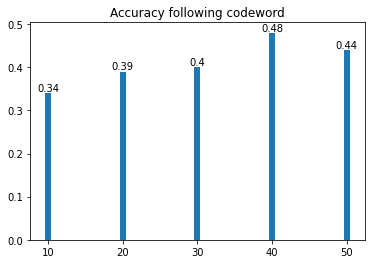

In [ ]:
# Print bar chart of accuracies per given codewords
plt.bar(codewords, accuracy_result)
plt.xticks(codewords)
plt.title("Accuracy following codeword")

for x, y in enumerate(codewords):
  plt.text(y, accuracy_result[x], accuracy_result[x], horizontalalignment='center', verticalalignment='bottom')

plt.show()